# Token Parameters - Annotation

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import re
import pickle
import json
import random
from itertools import islice
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Union, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import vec4gloss
from vec4gloss import check_hashes    
from vec4gloss import (
    AnnotFrameInfo, RatingFrameInfo, TokenParam
)
from vec4gloss import TokenStat, SequenceStat

## Data dependencies

```
30.41 => ..\data\annot_tokenparams_list.pkl 1ff297
```

In [3]:
annot_info_path = "../data/annot_tokenparams_list.pkl"
_ = check_hashes([annot_info_path])

..\data\annot_tokenparams_list.pkl 1ff297


## Load resources

In [4]:
annot_infos = pickle.loads(Path(annot_info_path).read_bytes())

In [5]:
len(annot_infos)

244

In [6]:
annot_infos[1]

(AnnotFrame(sense_id=5071201, POS='D', head_word='實地', definition='表親身體驗後述事件。', event_role='patient ', schemas=[Scheme(type='--', start=0, end=1), Scheme(type='mod', start=1, end=3), Scheme(type='action', start=3, end=5), Scheme(type='event', start=5, end=9)]),
 [<TokenParam 　表: F/A/D/R/X 1.00/1.00/1.00/1.00/0.00>,
  <TokenParam 　親: F/A/D/R/X 0.00/0.00/0.00/0.00/0.00>,
  <TokenParam 　身: F/A/D/R/X 0.91/0.67/0.39/0.04/0.00>,
  <TokenParam 　體: F/A/D/R/X 0.02/0.04/0.76/0.86/0.00>,
  <TokenParam 　驗: F/A/D/R/X 1.00/1.00/0.01/0.92/0.00>,
  <TokenParam 　後: F/A/D/R/X 0.00/0.00/0.00/0.00/0.00>,
  <TokenParam 　述: F/A/D/R/X 0.02/0.37/1.00/0.15/0.00>,
  <TokenParam 事件: F/A/D/R/X 0.38/0.08/0.12/0.67/0.00>])

In [7]:
frame_x = annot_infos[1]

In [8]:
chunk_stats = []
for frame_i, frame_x in enumerate(tqdm(annot_infos)):
    annot = frame_x[0]
    params = frame_x[1]
    ## adverb only
    if annot.POS != "D":
        continue

    bychar_stats = []    
    for param_x in params:
        stat_x = TokenStat(param_x)
        bychar_stats.extend([stat_x]*len(param_x.token_text))
    for schema_x in annot.schemas:    
        schema_type = schema_x.type
        s, e = schema_x.start, schema_x.end
        semanticness_x = np.median([x.semanticness() for x in bychar_stats[s:e]])
        contextualness_x = np.median([x.contextualness() for x in bychar_stats[s:e]])
        chunk_stats.append({
            "frame_idx": frame_i,
            "text": annot.definition[s:e],
            "event_role": annot.event_role,
            "type": schema_type,
            "semanticness": semanticness_x,
            "contextualness": contextualness_x
        })

  0%|          | 0/244 [00:00<?, ?it/s]

In [9]:
chunk_stats_df = pd.DataFrame.from_records(chunk_stats)

In [10]:
## only include schema types occured in more than 10% of the sequences
len(annot_infos)

244

In [11]:
type_stats = chunk_stats_df.drop(["frame_idx", "text", "event_role"], axis=1)\
    .groupby("type")\
    .agg(n=('semanticness', len), 
         semanticness=('semanticness', np.median),
         contextualness=('contextualness', np.median),)\
    .query("n>24.4 and type!='--'")\
    .sort_values("semanticness", ascending=False)

In [12]:
type_stats

,n,semanticness,contextualness
type,,,
neg,34,1.447938,1.651243
noun,48,0.908329,3.152485
scope,67,0.753869,1.540626
mod,67,0.728925,0.688785
action,159,0.237417,2.720058
event,162,0.024563,0.295381


Text(0.5, 1.0, 'Event annotations types')

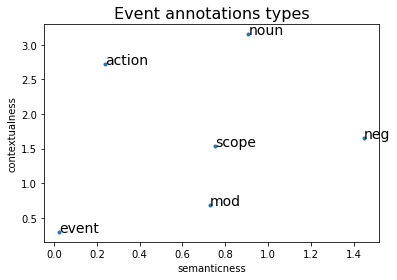

In [13]:
plt.plot(type_stats.semanticness, type_stats.contextualness, '.')
for i in range(type_stats.shape[0]):
    plt.text(type_stats.semanticness[i], type_stats.contextualness[i], 
             type_stats.index.values[i], fontsize=14)
plt.xlabel("semanticness")
plt.ylabel("contextualness")
plt.title("Event annotations types", fontsize=16)

In [14]:
def list_type_text(schema_type):
    return " ".join(chunk_stats_df.loc[chunk_stats_df.type==schema_type, "text"].tolist())

In [15]:
list_type_text("neg")

'不 沒有 不 沒有 未 不 不 不 不 不必 沒有 不 沒有 非 非 不 不 無法 不 不 不長 還沒 不 不 不 不 無法 沒有 不 沒有 不 沒有 不 否定'

In [16]:
list_type_text("action")

'去做 體驗 達到 成立 完成 發生 做 做 做 發生 進行 持續 進行 產生 進行 進行 涉及 設定 做 做到 做 進行 從事 進行 接 發生 做 進行 他人知道 達到 成立 做 做 發生 做 出現 發生 發生 發生 確定 詢問原因 持續 發生 發生 發生 涵蓋 改變 發展 造成 包含 直接參與 發生 進行 觀察到 做 發展 做 發生 發生 發生 發生 發生 驚訝 完成 影響 進行 發生 做 預測 發生 強調 繼續 開始 令人感到意外 同時 發生 發生 發生 發生過 發生 發生 經過 成立 變化 實際 持續 間斷 達到 發展到 發生 實現 牽涉 強調 發生 已達成 發生 發生 發生 表達 發生 競爭以取得 做 做 做 肯定 完成 進展 完成 想辦法 完成 利用 進行 進行 提出 進行 進行 說話 發生或完成 預期 發生 發生 存在 進行 達到 做 允許 發生 發生 發生過 導致 做 做 經歷 堅持進行 進行 進行 進行 進行 做 發生 做 做 完成 實現 做 做 認為 做 做 完成 影響到 成立 進行 進行 請求 進行 接續 作評價 肯定'

In [17]:
list_type_text("time")

'很短的時間內 時間 發生時間點 過去 現在 始 終 最後 後述時段 開始 結束 特定時間參考點 時間 一段時間 發生 同一時段 未來 期限 很短的時間 過去到現在 現在 時段'

In [18]:
list_type_text("noun")

'預期中 條件 預期 預期 足夠的時間 預期的效果 任何限制 其他媒介 受特定條件的限制 能力或條件不夠的情況 條件 其他媒介 趣味 頻率 疑問 肯定 現場 道理 相同動作 時段 間隔 預期 合理條件 假設的時間 主觀評價 前述描述 後述描述 目的 後述變化 立場 比例 機會 個人意願 能力 能力 後述時間或狀況 要求 重要影響 預期效果 能力 需要的時候 必要條件 可能性 願望 必要 條件 他人 語氣'